In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.utils.plot_utils import *
from csbdeep.data.transform import Transform

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.models.sample_patches import sample_patches

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import gputools

from one_cycle_lr.lr_finder import *

np.random.seed(42)
lbl_cmap = random_label_cmap()

%reload_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Load sample data

In [2]:
# X = sorted(glob('/home/qzt/data/centuri/train/images/*.tif'))
# Y = sorted(glob('/home/qzt/data/centuri/train/masks/*.tif'))
X = sorted(glob('/home/lis-paul/Nextcloud/dsb2018_sub1/images/*.tif'))
Y = sorted(glob('/home/lis-paul/Nextcloud/dsb2018_sub1/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
X[0]

'/home/lis-paul/Nextcloud/dsb2018_sub1/images/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1.tif'

In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 292/292 [00:01<00:00, 210.61it/s]


In [4]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

#manual assign train/val index for debugging
# ind_train = [1,2,3,4]
# ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 292
- training:       248
- validation:      44


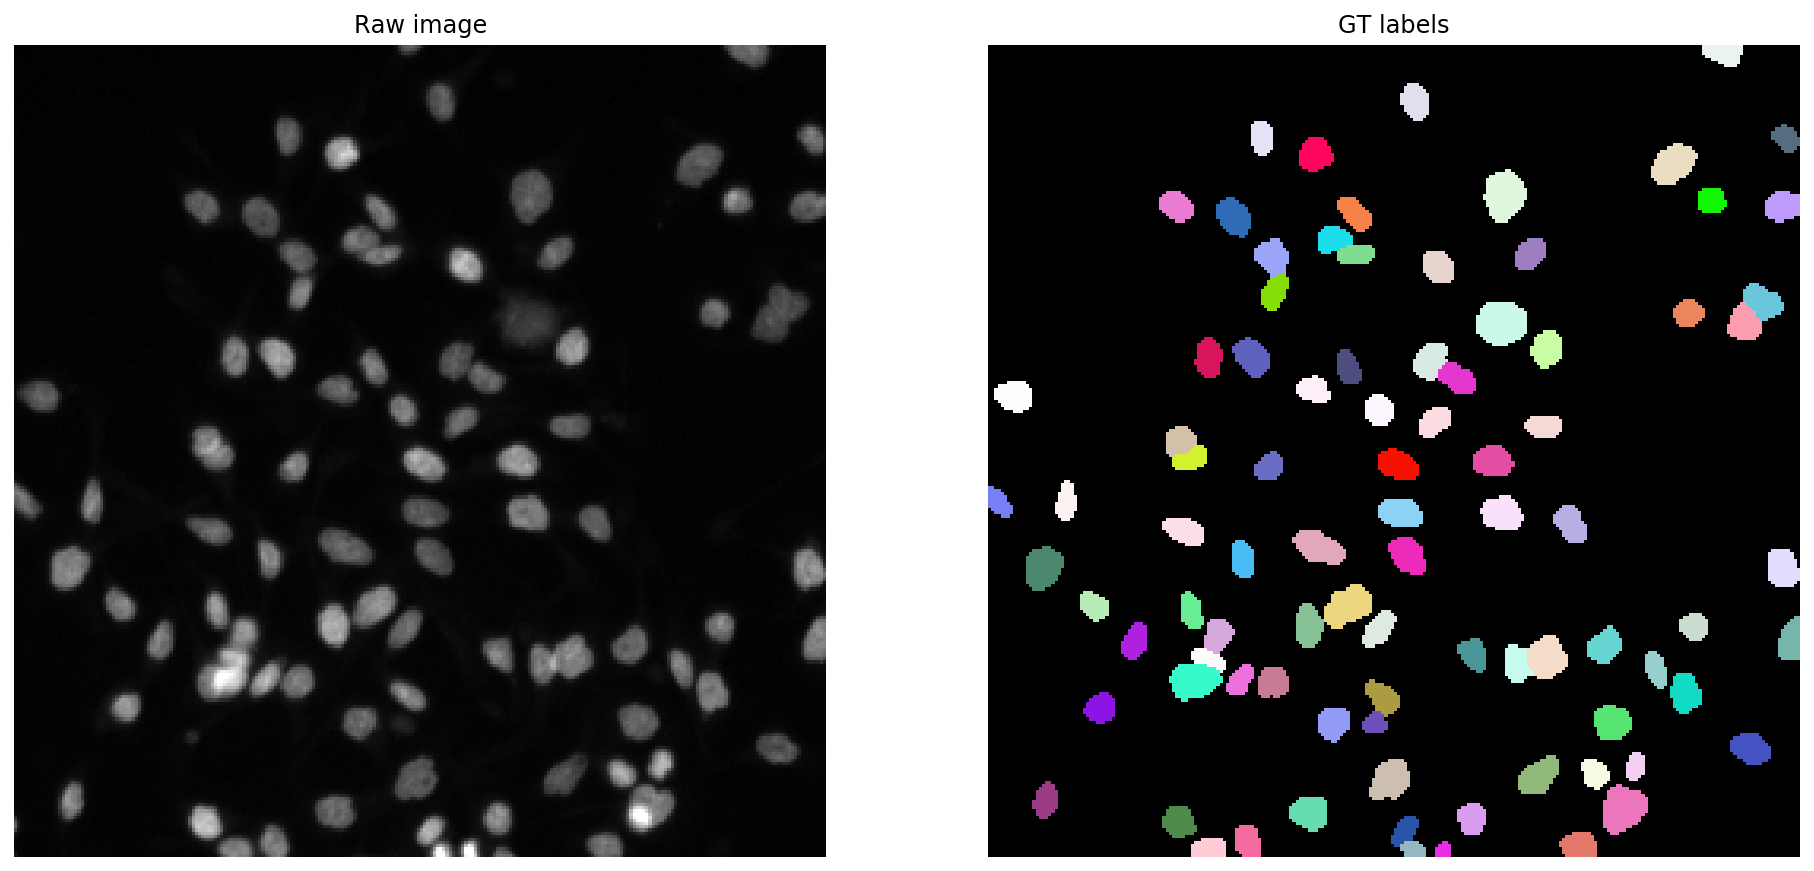

In [5]:
i = 0
img, lbl = X[i], Y[i]
img, lbl = X_val[0], Y_val[0]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

## Try with other augmentation packages and use stardist generator pipe (keras sequence) 

In [6]:
# import cv2
from albumentations import *

In [7]:
AUGMENTATIONS_TRAIN = Compose([
    Flip(p=0.5),
    ShiftScaleRotate(scale_limit=(0.5, 0.1), rotate_limit=45, interpolation=0, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    Downscale(scale_min = 0.25, scale_max=0.25, p=0.5),
    ElasticTransform(alpha=1000, sigma=100,p=0.5)
])

In [9]:
# data_train = StarDistData2D(X_trn, Y_trn, batch_size=32, n_rays=32, patch_size=(256,256), grid=(2,2), augmenter=AUGMENTATIONS_TRAIN, shape_completion=False)


# XX, YY = data_train[0]

# X,dist_mask = XX
# prob,dist = YY

# plot_some(X, dist_mask, prob, dist, x_inch=30, y_inch=20)

## Debug validation data part

In [27]:
validation_data=(X_val,Y_val)
data_kwargs = {'n_rays': 32, 'patch_size': (256, 256), 'grid': (2, 2), 'shape_completion': False, 'b': 32, 'use_gpu': False, 'foreground_prob': 0.9}
data_val = StarDistData2D(*validation_data, batch_size=1, **data_kwargs)

## Dig into the model

In [8]:
gputools_available()

True

In [9]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_batch_size = 32,  #no gpu
    train_epochs = 400,
    train_steps_per_epoch = 100,
    train_one_cycle_lr_max = 0.003,
    y_range = [0.0,64.0]
#     unet_batch_norm=True,
#     train_learning_rate=0.0003  #(3e-3)
    
#     net_input_shape = (X_trn[0].shape[0], X_trn[0].shape[1], n_channel)
)

conf

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=32, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_one_cycle_lr_max=0.003, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=True, y_range=[0.0, 64.0])

In [10]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)

In [11]:
model = StarDist2D(conf, name='stardist_tune', basedir='tune5_c0_csbsub')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


/home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as Activation) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [12]:
model.keras_model.summary()
# #check the trainable status in each layer
# for l in model.keras_model.layers:
#     print(l, l.trainable)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 3 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

## Freeze all the layers except the last n 

In [12]:
for l in model.keras_model.layers:
    print(l, l.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f520e886c10> False
<keras.layers.convolutional.Conv2D object at 0x7f520e894150> True
<keras.layers.convolutional.Conv2D object at 0x7f520e8942d0> True
<keras.layers.pooling.MaxPooling2D object at 0x7f52199dfd90> True
<keras.layers.convolutional.Conv2D object at 0x7f520e070c50> True
<keras.layers.convolutional.Conv2D object at 0x7f520e009150> True
<keras.layers.pooling.MaxPooling2D object at 0x7f520e070e90> True
<keras.layers.convolutional.Conv2D object at 0x7f520e0371d0> True
<keras.layers.convolutional.Conv2D object at 0x7f520e037450> True
<keras.layers.pooling.MaxPooling2D object at 0x7f520e070bd0> True
<keras.layers.convolutional.Conv2D object at 0x7f520df79fd0> True
<keras.layers.convolutional.Conv2D object at 0x7f520df95d90> True
<keras.layers.pooling.MaxPooling2D object at 0x7f520e009a90> True
<keras.layers.convolutional.Conv2D object at 0x7f520df5f950> True
<keras.layers.convolutional.Conv2D object at 0x7f520df5f910> True
<keras.

In [13]:
# freeze all the layers except the last 3 --> only keep feature layer, prob, dist trainable
for l in model.keras_model.layers[:-5]:
    l.trainable = False

for l in model.keras_model.layers:
    print(l, l.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f4aa0092150> False
<keras.layers.convolutional.Conv2D object at 0x7f4aa0092490> False
<keras.layers.convolutional.Conv2D object at 0x7f4aa2607850> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4aa25a2350> False
<keras.layers.convolutional.Conv2D object at 0x7f4a7c02c4d0> False
<keras.layers.convolutional.Conv2D object at 0x7f4a7c02c9d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4a7c02c710> False
<keras.layers.convolutional.Conv2D object at 0x7f4a7c0539d0> False
<keras.layers.convolutional.Conv2D object at 0x7f4a5c5c0390> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4a7c02c3d0> False
<keras.layers.convolutional.Conv2D object at 0x7f4a5c5eefd0> False
<keras.layers.convolutional.Conv2D object at 0x7f4a5c586150> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4a7c042d90> False
<keras.layers.convolutional.Conv2D object at 0x7f4a5c550e10> False
<keras.layers.convolutional.Conv2D object at 0x7f4a5c569ad0>

model need to be compiled again after setting the trainable state

In [14]:
model.prepare_for_training()
model.keras_model.optimizer

## load pretrained model

In [15]:
# # load weights into current model in h5 format (keras)
# model.keras_model.load_weights("tune_a1_xenopus/stardist_tune/weights_last.h5")
# print("Loaded model from disk")

In [16]:
# load weights into current model in h5 format (keras)
model.keras_model.load_weights("../../models/stardist_depth_3_augment_True_grid_2_2_epochs_800/weights_last.h5")
print("Loaded model from disk")

Loaded model from disk


In [17]:
conf

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=32, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_one_cycle_lr_max=0.003, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0, 'verbose': True}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=True, y_range

In [18]:
AUGMENTATIONS_TRAIN

Compose([
  Flip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(-0.0625, 0.0625), scale_limit=(0.5, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=0, border_mode=4, value=None, mask_value=None),
  Downscale(always_apply=False, p=0.5, scale_min=0.25, scale_max=0.25, interpolation=0),
  ElasticTransform(always_apply=False, p=0.5, alpha=1000, sigma=100, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None, approximate=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

## Test LRFinder 

In [98]:
# model is a Keras model
lr_finder = LRFinder(model.keras_model)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(data_train, start_lr=1e-8, end_lr=1.0)

Epoch 1/13
8/8 [==============================] - 39s 5s/step - loss: 0.4211 - prob_loss: 0.0819 - dist_loss: 1.6961 - prob_kld: 0.0075 - dist_relevant_mae: 1.6956 - dist_relevant_mse: 10.5673
Epoch 2/13
1/8 [==>...........................] - ETA: 24s - loss: 0.3900 - prob_loss: 0.0809 - dist_loss: 1.5454 - prob_kld: 0.0080 - dist_relevant_mae: 1.5450 - dist_relevant_mse: 6.0112

Min. loss grad point, lr: 1.4454397678775877e-08, loss: 0.42443979530817066


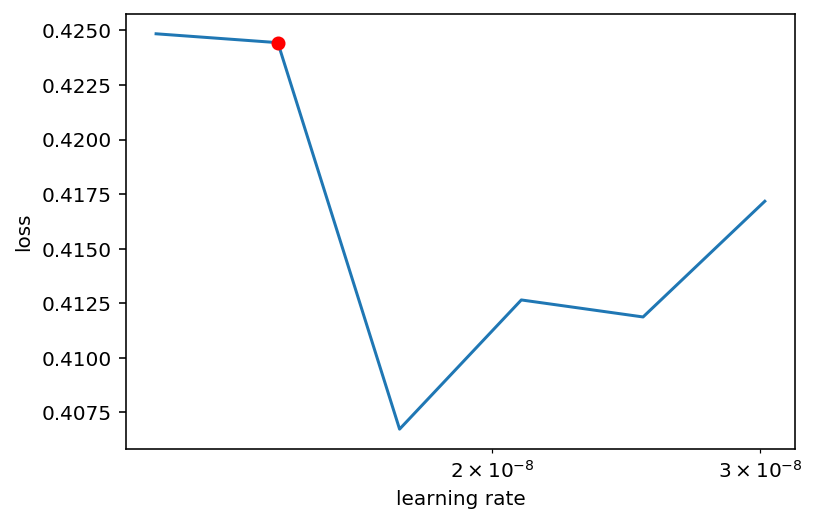

In [99]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(skip_start=1, skip_end=1, suggestion=True)

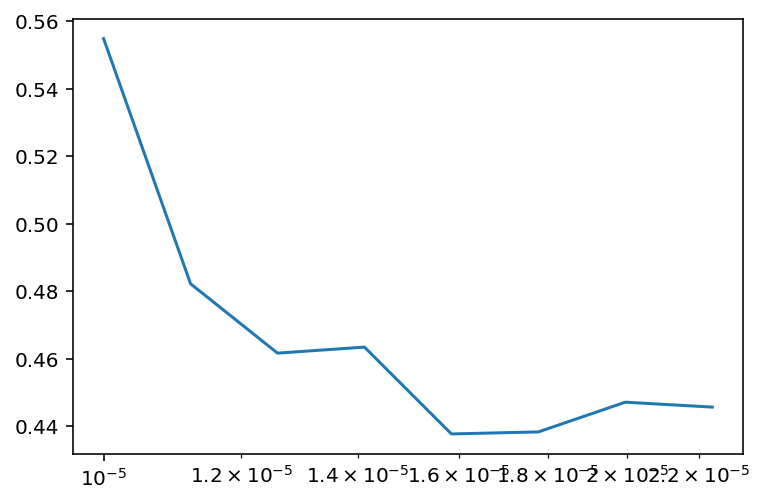

In [80]:
plt.plot(lr_finder.lrs, lr_finder.losses)
plt.xscale('log')

## Start training

In [19]:
# %debug
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=AUGMENTATIONS_TRAIN)

Epoch 1/400
100/100 [==============================] - 338s 3s/step - loss: 5.8508 - prob_loss: 0.0993 - dist_loss: 28.7574 - prob_kld: 0.0244 - dist_relevant_mae: 28.7542 - dist_relevant_mse: 1159.8315 - val_loss: 3.2939 - val_prob_loss: 0.1091 - val_dist_loss: 15.9244 - val_prob_kld: 0.0246 - val_dist_relevant_mae: 15.9238 - val_dist_relevant_mse: 380.3343
- OneCycleScheduler, lr: 0.00012049345203519763
Epoch 2/400
100/100 [==============================] - 305s 3s/step - loss: 3.1304 - prob_loss: 0.0989 - dist_loss: 15.1576 - prob_kld: 0.0239 - dist_relevant_mae: 15.1573 - dist_relevant_mse: 365.7108 - val_loss: 2.7026 - val_prob_loss: 0.1024 - val_dist_loss: 13.0013 - val_prob_kld: 0.0179 - val_dist_relevant_mae: 13.0011 - val_dist_relevant_mse: 255.2263
- OneCycleScheduler, lr: 0.0001219734699534139
Epoch 3/400
100/100 [==============================] - 307s 3s/step - loss: 2.0368 - prob_loss: 0.0976 - dist_loss: 9.6961 - prob_kld: 0.0224 - dist_relevant_mae: 9.6959 - dist_relevan

In [11]:
model.keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 3 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [20]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:10<00:02,  1.59it/s, 0.465 -> 0.889]


Using optimized values: prob_thresh=0.46396, nms_thresh=0.4.
Saving to 'thresholds.json'.


{'prob': 0.4639601707458496, 'nms': 0.4}

In [22]:
%pwd

'/home/lis-paul/stardist/examples/2D'

In [21]:
model.export_TF(fname='tune5_c0_csbsub')